# Importing the data

In [1]:
import pandas as pd

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                   names=['age','workclass','fnlwgt', 'education','education_num','marital_status',
                          'occupation','relationship','race','sex','capital_gain','capital_loss',
                          'hours_per_week', 'native_country','label'])

In [2]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
import diffprivlib as dp
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.random.seed(89)

In [6]:
acc = dp.BudgetAccountant()
acc.set_default()

BudgetAccountant()

# Extracting personal information through differential privacy

Let's try and determine the `capital-gain` for the 0th row of the dataset. The actual answer is 2174, but using differential privacy tools, can we recover this value?

## Histogram
We can try and hone in on a broad range in which the value lies using a histogram. For population statistics, histograms can produce highly-accurate results, but for statistics on individuals, the results are typically too noisy to draw definitive conclusions

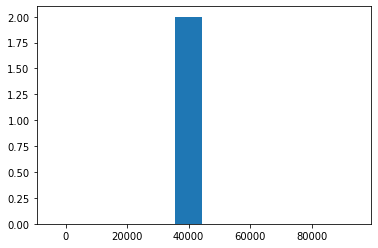

In [7]:
hist, bins = dp.tools.histogram(data['capital_gain'][0], range=(0, 100000))

plt.bar(bins[:-1], hist, width=10000*.9)
plt.show()

We can re-run the histogram query many times, and the value will begin to emerge, but this is eating into our privacy budget left to spend. And even so, the results won't necessarily be conclusive.

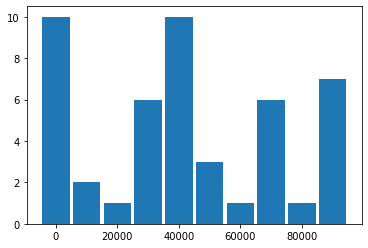

In [8]:
hist = 0

for i in range(10):
    _hist, bins = dp.tools.histogram(data['capital_gain'][0], range=(0, 100000), epsilon=1)
    hist += _hist

plt.bar(bins[:-1], hist, width=10000*.9)
plt.show()

## Mean
`diffprivlib` doesn't have any way to extract values from a dataset by default, but we can extract values by using the `mean` function over a single datapoint. Without differential privacy, this will return the original value, but when differential privacy is applied, the noise renders the output unreliable.

In [9]:
dp.tools.mean(data['capital_gain'][0], bounds=(0, 100000))

96297.75748703239

## Count

We can similarly use the `count_nonzero` function to try and hone in on the value. Again, the noise added makes this query unreliable too.

In [10]:
dp.tools.count_nonzero(data['capital_gain'][0] > 5000)

0

In [11]:
dp.tools.count_nonzero(data['capital_gain'][0] < 7500)

0

## Differencing attack: Histogram

A common attack in deterministic anonymisation systems is to run the same query on two datasets (once on the full dataset, and once on the full dataset without the target entry) and using the difference between the two results to reconstruct the original. With differential privacy, this attack is no longer feasible.

In fact,the result is likely to be worse than the naive approach, because noise is being added twice.

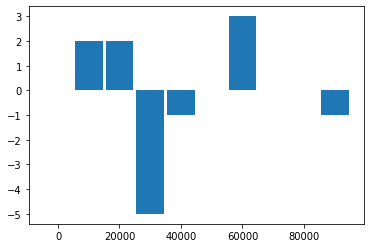

In [12]:
hist_full, bins = dp.tools.histogram(data['capital_gain'], range=(0, 100000))
hist_less, _ = dp.tools.histogram(data['capital_gain'][1:], range=(0, 100000))

plt.bar(bins[:-1], hist_full - hist_less, width=10000*.9)
plt.show()

## Differencing: Mean

Similarly, we can run a differencing attack using the mean, but differential privacy protects against this too.

In [20]:
mean_full = dp.tools.mean(np.array(data['capital_gain']), bounds=(0, 100000))
mean_less = dp.tools.mean(np.array(data['capital_gain'][1:]), bounds=(0, 100000))

print("Sensitive value estimate: %.2f" % (mean_full * 32561 - mean_less * 32560))

Sensitive value estimate: 383669.24


In comparison, without differential privacy we can recover the original value exactly.

In [21]:
nonpriv_val = np.mean(data['capital_gain']) * 32561 - np.mean(data['capital_gain'][1:]) * 32560

print("Non-private differencing attack: %.2f" % nonpriv_val)

Non-private differencing attack: 2174.00


# Accuracy on population statistics

We have shown that differential privacy can robustly defend against extracting information about an individual. But on population statistics, differential privacy can deliver reliable estimates.

## Histograms

For typical datasets, a differentially private histogram will be indistinguishable from a non-private one.

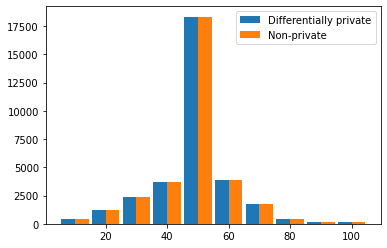

In [15]:
hist_dp, bins = dp.tools.histogram(data['hours_per_week'], range=(0, 100))
hist_np, _ = np.histogram(data['hours_per_week'], range=(0, 100))
w = 4.5

plt.bar(bins[1:] - w/2, hist_dp, width=w, label="Differentially private")
plt.bar(bins[1:] + w/2, hist_np, width=w, label="Non-private")
plt.legend()

Similarly, for typical datasets, the error in population statistics will be small.

In [24]:
mean_np = np.mean(data['capital_gain'])
mean_dp = dp.tools.mean(np.array(data['capital_gain']), bounds=(0, 100000))

print("Capital gain:\nNon-private mean: %.2f\nPrivate mean: %.2f (%+.5f%%)" % 
      (mean_np, mean_dp, (mean_dp - mean_np) / mean_np))

Capital gain:
Non-private mean: 1077.65
Private mean: 1077.38 (-0.00025%)


We can still sub-index the data, and get accurate estimates.

In [25]:
mean_np = np.mean(data['capital_gain'][data['capital_gain']>0])
mean_dp = dp.tools.mean(np.array(data['capital_gain'][data['capital_gain']>0]), bounds=(0, 100000))

print("Strictly positive capital gain:\nNon-private mean: %.2f\nPrivate mean: %.2f (%+.5f%%)" % 
      (mean_np, mean_dp, (mean_dp - mean_np) / mean_np))

Strictly positive capital gain:
Non-private mean: 12938.54
Private mean: 12910.89 (-0.00214%)
